simpleSFC.ipynbをコピーしただけ

In [1]:
import abcEconomics as abce
from abcEconomics import Simulation, Agent, Household, Firm
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline



#   パラメータ群
N_HH = 10**3    #   家計の数
#P = None   #   物価水準
corporation_tax_rate = 0.2
consume_tax_rate = 0.1
devidend_rate = 0.1
target_rate_of_profit_for_companies = 0.3


simulation = Simulation(name='simpleSFC', processes=1)



class Household(Household, Agent):
    def init(self, family_name, potential_wage):
        self.family_name = family_name
        self.create("MS", 0)
        self.create("L", 0)
        self.wage = max(0, potential_wage)  #   給料
        self.dividend_income = 0 #   受取配当の合計
        self.income_from_government = None  #   政府からの収入
        self.income = max(180, self.wage)  #   収入の合計
        self.income_log = np.zeros(5) + self.income
        self.net_lending = 0
        self.income_tax = 0
        self.consume_tax = 0
        self.tax = 0
        self.consumption = None
        self.real_consumption = 0.7*self.wage
        self.potential_wage = potential_wage
        self.delta_L = 0
        self.delta_MS = 0
    
    def decide_wage_s1(self, wage_total_0, wage_total_1, potential_wage_SD):
        self.potential_wage *= wage_total_1/wage_total_0
        n = potential_wage_SD/7
        a = np.sqrt(potential_wage_SD**2 + n**2)
        self.potential_wage += n*np.random.randn()*(potential_wage_SD/a) + 2*potential_wage_SD*(a/potential_wage_SD - 1)
        if self.potential_wage <= 0:
            self.wage = 0
        else:
            self.wage = self.potential_wage
        return self.wage
    
    def decide_wage_s2(self, wage_total_1, wage_total_2):
        self.wage *= wage_total_1/wage_total_2

    def borrow_loan(self, price):
        self.create("L", price)
        self.create("MS", price)
        self.delta_L += price
        self.delta_MS += price
        self.sell(("bank", 0), good="L", currency="MS", price=1, quantity=price)
    
        #   銀行に返済
    def return_loan_1(self):
        price = min(self["L"], self["MS"])
        self.sell(("bank", 0), good="L", currency="MS", price=1, quantity=price)
    
    def return_loan_2(self):
        price = min(self["L"], self["MS"])
        self.destroy("L", price)
        self.destroy("MS", price)
        self.delta_L -= price
        self.delta_MS -= price

    def cal_consume_volume(self, mean_wage, price_lst):
        center, width = 5*mean_wage, 5*mean_wage
        baseline, variable = 0.1, 0.7
        u = np.sum((self.income_log[:-1] - self.income_log[1:])/(np.arange(4) + 1))
        s = max(150, self.income + 4.0*u) + 0.1*self["MS"]
        t = (s - center)/width
        CR = baseline
        if t <= 10:
            CR += variable / (np.exp(t) + 1)
        if self.real_consumption is None:
            self.consumption = CR*self.income
        else:
            self.consumption = 0.5*CR*self.income + 0.5*self.real_consumption*price_lst[0]
        if self["MS"] < 2*self.consumption:
            self.borrow_loan(2*self.consumption - self["MS"] + 1)
        
    def consume(self, price_lst):
        self.destroy("MS", self.consumption)
        self.delta_MS -= self.consumption
        self.net_lending -= self.consumption
        self.buy(("firmC", 0), good='product', quantity=self.consumption/price_lst[0], price=price_lst[0], currency="MS")
        self.real_consumption = self.consumption / price_lst[0]
        
    def print_possessions(self):
        print("     " + str(dict(self.possessions())))
    
    def cal_consume_and_income_tax(self, mean_wage):
        self.consume_tax = consume_tax_rate*self.consumption
        t = np.exp((-self.wage+10*mean_wage)/(20*mean_wage))
        self.income_tax = 0.5*t/(t + 1)*self.wage
        if self["MS"] < 2*self.consume_tax + 2*self.income_tax:
            self.borrow_loan(2*self.consume_tax + 2*self.income_tax - self["MS"] + 1)
        
    def pay_consume_and_income_tax(self):
        self.destroy("MS", self.consume_tax)
        self.delta_MS -= self.consume_tax
        self.net_lending -= self.consume_tax
        self.buy(("bank", 0), good="consume_tax", quantity=1, price=self.consume_tax, currency="MS")
                
        self.destroy("MS", self.income_tax)
        self.delta_MS -= self.income_tax
        self.net_lending -= self.income_tax
        self.buy(("bank", 0), good="income_tax", quantity=1, price=self.income_tax, currency="MS")
        self.tax = self.consume_tax + self.income_tax
    
    def receive_wage(self):
        self.wage = 0
        for offer in self.get_offers("wage"):
            p = offer.price * offer.quantity
            self.create("MS", p)
            self.delta_MS += p
            self.wage += p
            self.net_lending += p
            self.reject(offer)

    def receive_dividend(self):
        self.dividend_income = 0
        for offer in self.get_offers("dividend"):
            price = offer.price * offer.quantity
            self.create("MS", price)
            self.delta_MS += price
            self.dividend_income += price
            self.net_lending += price
            self.reject(offer)
    
    def receive_subsidy(self, bank, mean_wage):
        self.income_from_government = 0
        if (self.wage + self.dividend_income) < mean_wage/2 and self["MS"] < mean_wage/2:
            p = mean_wage/2 - (self.wage + self.dividend_income)
            self.create("MS", p)
            self.delta_MS += p
            self.net_lending += p
            self.income_from_government += p
            self.create("subsidy", 1)
            self.sell(("bank", 0), good="subsidy", quantity=1, price=p, currency="MS")
        
    def cal_income(self):
        self.income = self.wage + self.dividend_income + self.income_from_government
        self.income_log[1:] = self.income_log[:-1]
        self.income_log[0] = self.income
    
    def create_dividend_right(self):
        self.create("dividend", 1)

    def output_wage(self):
        return self.wage
    
    def output_potential_wage(self):
        return self.potential_wage
    
    def say_MS(self):
        return self["MS"]
    def say_L(self):
        return self["L"]
    
    def say_delta_MS(self):
        return self.delta_MS
    
    def reset_delta_and_flow(self):
        self.delta_L = 0
        self.delta_MS = 0
        self.income_tax = 0
        self.consume_tax = 0
        self.tax = 0
        self.net_lending = 0

    def output_income(self):
        return self.income
    
    def reset_fictitious_goods(self):
        self.destroy("consume_tax", self["consume_tax"])
        self.destroy("income_tax", self["income_tax"])
        self.destroy("wage", self["wage"])
        self.destroy("product", self["product"])
        
    
agent_params = [
    {
        "family_name":str(i), 
        "potential_wage":300*np.random.randn()+300,
    } for i in range(N_HH)
]
households = simulation.build_agents(Household, "household", agent_parameters=agent_params)




class FirmC(Firm, Agent):
    def init(self, firm_name, wage_sum):
        self.firm_type = "typeC"
        self.firm_name = firm_name
        self.create("MS", 0)
        self.create("L", 0)
        self.create("product", 0)
        self.create("product_4_G", 0)
        self.price_of_product = 1
        self.profit = 0  #   利潤
        self.profit_after_tax = 0    #   税引後当期純利益
        self.dividend = 0    #   配当
        self.undistributed_profit = 0   #   内部留保
        self.net_lending = 0
        self.wage_sum = wage_sum
        self.firm_income = 0
        self.tax_sum = 0
        self.delta_L = 0
        self.delta_MS = 0
    
    def decide_price(self):
        #   企業にとっての利潤目標値からの乖離度合を表す。t>0のときは、収益が目標に届かないので、価格を上げる
        t = target_rate_of_profit_for_companies - (self.firm_income - self.wage_sum)/self.firm_income
        if t > 0:
            self.price_of_product *= 1 + t
        
    def output_price(self):
        return self.price_of_product

    def cal_profit(self):
        self.profit = self.firm_income - self.wage_sum
    
    def cal_profit_after_tax(self):
        self.profit_after_tax = self.profit - self.tax_sum
        self.undistributed_profit = (1 - devidend_rate)*max(0, self.profit_after_tax)
        if abs(self.delta_MS - self.delta_L - self.net_lending) > 1:
            print("企業のフローの会計的一貫性が崩れている", self.delta_MS - self.delta_L - self.net_lending)
            print(self.delta_MS, self.delta_L, self.net_lending)
    
    def cal_corporation_tax_volume(self):
        #   いったん銀行に支払って、銀行が政府に支払う
        if self.profit <= 0:
            self.tax_sum = 0
            return None
        self.tax_sum = corporation_tax_rate*self.profit
        self.borrow_loan(1 + self.tax_sum)

    def pay_corporation_tax(self):
        self.destroy("MS", self.tax_sum)
        self.delta_MS -= self.tax_sum
        self.net_lending -= self.tax_sum
        self.buy(("bank", 0), good="corporation_tax", quantity=1, price=corporation_tax_rate*self.profit, currency="MS")
    
    def sell_to_government(self):
        for offer in self.get_offers("product_4_G"):#   受注した分をすべて生産する
            price = offer.price * offer.quantity
            self.create("MS", price)
            self.delta_MS += price
            self.firm_income += price
            self.net_lending += price
            self.reject(offer)

    def sell_to_households(self):
        self.firm_income = 0
        for offer in self.get_offers("product"):#   受注した分をすべて生産する
            price = offer.price * offer.quantity
            self.create("MS", price)
            self.delta_MS += price
            self.firm_income += price
            self.net_lending += price
            self.reject(offer)
        
    def print_possessions(self):
        print("     " + str(dict(self.possessions())))

    def input_wage_sum(self, households):
        self.wage_sum = sum(households.output_wage()[0])
    

    #   銀行から借り入れ
    def borrow_loan(self, price):
        self.create("L", price)
        self.create("MS", price)
        self.delta_L += price
        self.delta_MS += price
        self.sell(("bank", 0), good="L", currency="MS", price=1, quantity=price)

    #   銀行に返済
    def return_loan_1(self):
        price = min(self["L"], self["MS"])
        self.sell(("bank", 0), good="L", currency="MS", price=1, quantity=price)
    
    def return_loan_2(self):
        price = min(self["L"], self["MS"])
        self.destroy("L", price)
        self.destroy("MS", price)
        self.delta_L -= price
        self.delta_MS -= price
            
    def pay_wage_1(self, households, nominal_wage_growth_rate=0.02):
        wage_total_0 = self.wage_sum
        wage_total_1 = (1 + nominal_wage_growth_rate)*wage_total_0
        potential_wage_SD = np.var(households.output_potential_wage()[0])**0.5
        households.decide_wage_s1(wage_total_0, wage_total_1, potential_wage_SD)
        wage_total_2 = sum(households.output_wage()[0])
        households.decide_wage_s2(wage_total_1, wage_total_2)
        self.wage_sum = wage_total_1
        self.borrow_loan(1 + wage_total_1)  #   賃金の支払いをいったん全額借り入れで賄う。コードを簡単にするため。

    def pay_wage_2(self, households):
        for household_id in range(len(households)):
            wage_price = households[household_id].output_wage()[0][0]
            #   self.wage_sum はすでに計算済みなので省略
            self.destroy("MS", wage_price)
            self.delta_MS -= wage_price
            self.net_lending -= wage_price
            self.buy(("household", household_id), good="wage", quantity=1, price=wage_price, currency="MS")
    
    def cal_dividend_volume(self):
        self.dividend = max(0, devidend_rate*self.profit_after_tax)
        self.borrow_loan(1 + self.dividend)   #   少し多めに借り入れる、5行下のMSが2*10^(-10)程度不足しています的なエラーを回避するため
        
    def pay_dividend(self, households):
        self.destroy("MS", self.dividend)
        self.delta_MS -= self.dividend
        self.net_lending -= self.dividend
        w_arr = np.array(households.say_MS()[0])
        w_arr[w_arr<0] = 0
        w_arr[w_arr<0.1*np.mean(w_arr)] = 0
        w_arr[np.random.rand(len(w_arr))>0.1] = 0
        if np.sum(w_arr) == 0:
            return None
        w_arr /= np.sum(w_arr)
        self.create("dividend", self.dividend + 1)
        for i, w in enumerate(w_arr):
            if w != 0:
                households[i].create_dividend_right()
                self.buy(("household", i), good="dividend", quantity=w*self.dividend, price=1, currency="MS")
    
    def say_income(self):
        return self.firm_income
    
    def reset_fictitious_goods(self):
        self.destroy("dividend", self["dividend"])
        self.destroy("corporation_tax", self["corporation_tax"])
        self.destroy("wage", self["wage"])
    
    def reset_delta_and_flow(self):
        self.delta_L = 0
        self.delta_MS = 0
        self.net_lending = 0

        #   値を次期に使う物は排除する必要がある
        self.profit = 0  #   利潤
        self.profit_after_tax = 0    #   税引後当期純利益
        self.dividend = 0    #   配当
        self.undistributed_profit = 0   #   内部留保
        self.net_lending = 0
        self.firm_income = 0
        self.tax_sum = 0
        self.delta_L = 0
        self.delta_MS = 0
    
    def output_fund_flow(self):
        return self.delta_MS, self.delta_L, self.net_lending
    
    def output_MS_L(self):
        return self["MS"], self["L"]
    
    def say_MS(self):
        return self["MS"]

        
agent_params = [
    {
        "firm_name":0,
        "wage_sum":np.sum(households.output_wage()[0]),
    }
]
firmC = simulation.build_agents(FirmC, 'firmC', agent_parameters=agent_params)




class Government(Agent):
    def init(self):
        self.create("HPM", 0)
        self.net_lending = 0
        self.expenditure = 0
        self.tax = 0
        self.delta_HPM = 0

    def receive_tax(self):
        self.consume_tax, self.income_tax, self.corporation_tax = 0, 0, 0
        for offer in self.get_offers("consume_tax"):   #   good=debtor, currency=creditor, price=1, quantity=price のsellオファーを受ける
            price = offer.quantity * offer.price
            self.destroy("HPM", price)
            self.delta_HPM -= price
            self.consume_tax += price
            self.net_lending += price
            self.reject(offer)

        for offer in self.get_offers("income_tax"):   #   good=debtor, currency=creditor, price=1, quantity=price のsellオファーを受ける
            price = offer.quantity * offer.price
            self.destroy("HPM", price)  #   貸方が減少
            self.delta_HPM -= price
            self.income_tax += price
            self.net_lending += price
            self.reject(offer)

        for offer in self.get_offers("corporation_tax"):   #   good=debtor, currency=creditor, price=1, quantity=price のsellオファーを受ける
            price = offer.quantity * offer.price
            self.destroy("HPM", price)  #   貸方が減少
            self.delta_HPM -= price
            self.corporation_tax += price
            self.net_lending += price
            self.reject(offer)

        self.tax = self.consume_tax + self.income_tax + self.corporation_tax

    def pay_gov_exp_2_firm(self, price_lst):
        self.expenditure += 300*N_HH*price_lst[0]
        self.net_lending -= self.expenditure
        self.create("HPM", self.expenditure)
        self.delta_HPM += self.expenditure
        self.buy(("bank", 0), good="product_4_G", quantity=300*N_HH, price=price_lst[0], currency="HPM")

    def pay_gov_exp_2_household(self):
        for offer in self.get_offers("subsidy"):
            price = offer.price * offer.quantity
            self.create("HPM", price)
            self.delta_HPM += price
            self.expenditure += price
            self.net_lending -= price
            self.reject(offer)
        
    def reset_delta_and_flow(self):
        self.delta_HPM = 0
        self.expenditure = 0
        self.tax = 0
    
    def reset_fictitious_goods(self):
        self.destroy("subsidy", self["subsidy"])
        self.destroy("consume_tax", self["consume_tax"])
        self.destroy("income_tax", self["income_tax"])
        self.destroy("corporation_tax", self["corporation_tax"])
        self.destroy("product_4_G", self["product_4_G"])
    
    def say_HPM(self):
        return self["HPM"]
    

government = simulation.build_agents(Government, "government", number=1)




class Bank(Agent):
    def init(self):
        self.create("L", 0)
        self.create("MS", 0)
        self.create("HPM", 0)
        self.delta_L = 0
        self.delta_MS = 0
        self.delta_HPM = 0
        self.net_lending = 0
    
    #   信用創造
    def monay_creation(self):
        for offer in self.get_offers("L"):   #   good="L", currency="MS", price=1, quantity=price のsellオファーを受ける
            price = offer.price * offer.quantity
            self.create("L", price)
            self.create("MS", price)
            self.delta_MS += price
            self.delta_L += price
            self.reject(offer)
    
    #   信用収縮
    def credit_shrinkage(self):
        for offer in self.get_offers("L"):   #   good="L", currency="MS", price=1, quantity=price のsellオファーを受ける
            price = offer.price * offer.quantity
            if -10**(-5) < self["L"] - price < 0:
                price = self["L"]
            self.destroy("L", price)
            self.destroy("MS", price)
            self.delta_MS -= price
            self.delta_L -= price
            self.reject(offer)
    
    def pay_corporation_tax(self):
        self.destroy("HPM", self.corporation_tax)
        self.destroy("MS", self.corporation_tax)
        self.delta_HPM -= self.corporation_tax
        self.delta_MS -= self.corporation_tax
        self.create("corporation_tax", 1)
        self.buy(("government", 0), good="corporation_tax", quantity=1, price=self.corporation_tax, currency="HPM")
        
    def receive_corporation_tax(self):
        self.corporation_tax = 0
        for offer in self.get_offers("corporation_tax"):
            self.corporation_tax += offer.price * offer.quantity
            self.reject(offer)
    
    def receive_gov_exp_2_firm(self):
        self.gov_exp_2_firm = 0
        for offer in self.get_offers("product_4_G"):
            self.gov_exp_2_firm += offer.price * offer.quantity
            self.reject(offer)

    def pay_gov_exp_2_firm(self):
        self.create("MS", self.gov_exp_2_firm)
        self.create("HPM", self.gov_exp_2_firm)
        self.delta_MS += self.gov_exp_2_firm
        self.delta_HPM += self.gov_exp_2_firm
        self.create("product_4_G", 1)
        self.buy(("firmC", 0), "product_4_G", quantity=1, price=self.gov_exp_2_firm, currency="MS")

    def receive_households_subsidy(self):
        self.create("HPM", self.subsidy)
        self.create("MS", self.subsidy)
        self.delta_HPM += self.subsidy
        self.delta_MS += self.subsidy
        self.create("subsidy", 1)
        self.sell(("government", 0), "subsidy", quantity=1, price=self.subsidy, currency="HPM")

    def pay_households_subsidy(self):
        self.subsidy = 0
        for offer in self.get_offers("subsidy"):
            self.subsidy += offer.price * offer.quantity
            self.reject(offer)

    def receive_consume_and_income_tax(self):
        #   MS や HPM は、taxを集計した後で計算する。
        self.consume_tax = 0
        for offer in self.get_offers("consume_tax"):
            self.consume_tax += offer.price * offer.quantity
            self.reject(offer)
        self.income_tax = 0
        for offer in self.get_offers("income_tax"):
            self.income_tax += offer.price * offer.quantity
            self.reject(offer)

    def pay_consume_and_income_tax(self):
        t = self.consume_tax + self.income_tax
        self.destroy("HPM", t)
        self.destroy("MS", t)
        self.delta_HPM -= t
        self.delta_MS -= t
        #   consume_tax と income_tax は集計が終わっているのでパス
        self.buy(("government", 0), good="consume_tax", quantity=1, price=self.consume_tax, currency="HPM")
        self.buy(("government", 0), good="income_tax", quantity=1, price=self.income_tax, currency="HPM")
    
    
    def reset_delta_and_flow(self):
        if abs(self.delta_L + self.delta_HPM - self.delta_MS) > 1:
            print("銀行の資金フローの整合性が取れていない")
        self.delta_L = 0
        self.delta_HPM = 0
        self.delta_MS = 0
        self.net_lending = 0
    
    def reset_fictitious_goods(self):
        self.destroy("subsidy", self["subsidy"])
        self.destroy("consume_tax", self["consume_tax"])
        self.destroy("income_tax", self["income_tax"])
        self.destroy("product_4_G", self["product_4_G"])
        self.destroy("product", self["product"])
    
    def say_MS(self):
        return self["MS"]
    def say_HPM(self):
        return self["HPM"]

bank = simulation.build_agents(Bank, "bank", number=1)




for r in range(100):
    print("round", r)
    simulation.advance_round(r)
    
    mean_wage = np.average(households.output_wage()[0])
    price_lst = firmC.output_price()[0]
    #   消費支出    需要主導のため、最初に実行するのがよいとの判断
        #   家計消費支出
    households.cal_consume_volume(mean_wage, price_lst)
    bank.monay_creation()
    households.consume(price_lst)
        #   政府消費支出
    government.pay_gov_exp_2_firm(price_lst)
    bank.receive_gov_exp_2_firm()
    bank.pay_gov_exp_2_firm()

    #   企業の生産と売り上げ
    firmC.sell_to_households()
    firmC.sell_to_government()

    #   賃金の支払い
    firmC.pay_wage_1(households)  #   households側の要求する賃金水準の更新、賃金と同額を借り入れる
    bank.monay_creation()
    firmC.pay_wage_2(households)    #   賃金の振り込みオファー
    households.receive_wage()   #   賃金の受け取り
    firmC.return_loan_1()     #   賃金用の借り入れのうち、返済で霧分を全額返済
    households.return_loan_1()
    bank.credit_shrinkage()
    firmC.return_loan_2()     #   賃金用の借り入れのうち、返済で霧分を全額返済
    households.return_loan_2()

    #   政府から家計への、低所得者への給付金
    households.receive_subsidy(bank, mean_wage)
    bank.pay_households_subsidy()
    bank.receive_households_subsidy()
    government.pay_gov_exp_2_household()

    #   所得税と消費税の支払い
    mean_wage = np.average(households.output_wage()[0])
    households.cal_consume_and_income_tax(mean_wage)
    bank.monay_creation()
    households.pay_consume_and_income_tax()
    bank.receive_consume_and_income_tax()
    bank.pay_consume_and_income_tax()

    #   企業の税引き前当期純利益の計算
    firmC.cal_profit()

    #   法人税の計算
    firmC.cal_corporation_tax_volume()
    bank.monay_creation()
    firmC.pay_corporation_tax()
    bank.receive_corporation_tax()
    firmC.return_loan_1()     #   賃金用の借り入れのうち、返済で霧分を全額返済
    bank.credit_shrinkage()
    firmC.return_loan_2()     #   賃金用の借り入れのうち、返済で霧分を全額返済
    bank.pay_corporation_tax()
    government.receive_tax()

    #   税引き後当期純利益の計算と、配当の支払い
    firmC.cal_profit_after_tax()
    firmC.cal_dividend_volume()
    bank.monay_creation()
    firmC.pay_dividend(households)
    households.receive_dividend()

    #   借入の一部返済
    firmC.return_loan_1()     #   賃金用の借り入れのうち、返済で霧分を全額返済
    households.return_loan_1()
    bank.credit_shrinkage()
    firmC.return_loan_2()     #   賃金用の借り入れのうち、返済で霧分を全額返済
    households.return_loan_2()

    #   家計の収入の集計
    households.cal_income()

    
    households.panel_log(goods=["MS", "L"])
    households.agg_log(variables=[
        "wage", "dividend_income", "income_from_government", "income", 
        "net_lending", "consumption", "real_consumption", "delta_L", "delta_MS"
    ])
    firmC.panel_log(goods=['MS', "L", "product", "product_4_G"])
    firmC.agg_log(variables=[
        "firm_name", "profit", "profit_after_tax", "dividend", "undistributed_profit", 
        "net_lending", "wage_sum", "firm_income", "tax_sum", "delta_L", "delta_MS", "price_of_product"
    ])
    government.panel_log(goods=["HPM"])
    government.agg_log(variables=[
        "net_lending", "expenditure", "tax", "delta_HPM",
    ])
    bank.panel_log(goods=["L", "MS", "HPM"])
    bank.agg_log(variables=["delta_L", "delta_MS", "delta_HPM"])

    #   価格改定
    firmC.decide_price()

    #   資金フローのリセット
    households.reset_delta_and_flow()
    bank.reset_delta_and_flow()
    firmC.reset_delta_and_flow()
    government.reset_delta_and_flow()

    #   仮想商品の削除
    households.reset_fictitious_goods()
    bank.reset_fictitious_goods()
    firmC.reset_fictitious_goods()
    government.reset_fictitious_goods()


simulation.finalize()

round 0
round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12
round 13
round 14
round 15
round 16
round 17
round 18
round 19
round 20
round 21
round 22
round 23
round 24
round 25
round 26
round 27
round 28
round 29
round 30
round 31
round 32
round 33
round 34
round 35
round 36
round 37
round 38
round 39
round 40
round 41
round 42
round 43
round 44
round 45
round 46
round 47
round 48
round 49
round 50
round 51
round 52
round 53
round 54
round 55
round 56
round 57
round 58
round 59
round 60
round 61
round 62
round 63
round 64
round 65
round 66
round 67
round 68
round 69
round 70
round 71
round 72
round 73
round 74
round 75
round 76
round 77
round 78
round 79
round 80
round 81
round 82
round 83
round 84
round 85
round 86
round 87
round 88
round 89
round 90
round 91
round 92
round 93
round 94
round 95
round 96
round 97
round 98
round 99

time only simulation  60.95
time with data  76.01


In [2]:
for file_name in os.listdir(simulation.path):
    print(file_name)

aggregated_bank.csv
aggregated_firmC.csv
aggregated_government.csv
aggregated_household.csv
aggregate_bank.csv
aggregate_firmC.csv
aggregate_government.csv
aggregate_household.csv
description.txt
panel_bank.csv
panel_firmC.csv
panel_government.csv
panel_household.csv


In [3]:
panel_firmC_df = pd.read_csv(simulation.path + '/panel_firmC.csv')
panel_firmC_df.head()

,index,MS,L,product,product_4_G,round,name
0,1,5.169374e+05,3.816911e+05,0,0,0,firmC0
1,2,1.030405e+06,7.671496e+05,0,0,1,firmC0
2,3,1.542646e+06,1.157099e+06,0,0,2,firmC0
3,4,2.049386e+06,1.550437e+06,0,0,3,firmC0
4,5,2.559757e+06,1.949822e+06,0,0,4,firmC0


In [4]:
panel_bank_df = pd.read_csv(simulation.path + '/panel_bank.csv')
panel_bank_df.head()

,index,L,MS,HPM,round,name
0,1,8.362258e+05,1.015671e+06,179445.615700,0,bank0
1,2,1.524001e+06,1.879396e+06,355395.166183,1,bank0
2,3,2.216314e+06,2.724816e+06,508501.302459,2,bank0
3,4,2.915093e+06,3.594831e+06,679738.288108,3,bank0
4,5,3.624791e+06,4.458921e+06,834129.752252,4,bank0


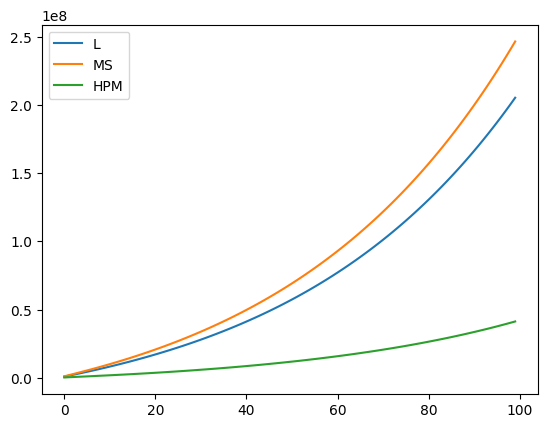

In [5]:
panel_hh_df = pd.read_csv(simulation.path + '/panel_household.csv')
panel_hh_df.head()
plt.plot(panel_hh_df["L"], label="L")
plt.plot(panel_hh_df["MS"], label="MS")
plt.legend()

In [6]:
plt.plot(panel_bank_df["L"], label="L")
plt.plot(panel_bank_df["MS"], label="MS")
plt.plot(panel_bank_df["HPM"], label="HPM")
plt.legend()

index
round
net_lending_ttl
net_lending_mean
net_lending_std
expenditure_ttl
expenditure_mean
expenditure_std
tax_ttl
tax_mean
tax_std
delta_HPM_ttl
delta_HPM_mean
delta_HPM_std


,index,round,net_lending_ttl,net_lending_mean,net_lending_std,expenditure_ttl,expenditure_mean,expenditure_std,tax_ttl,tax_mean,tax_std,delta_HPM_ttl,delta_HPM_mean,delta_HPM_std
0,1,0,-179445.615700,-179445.615700,0.0,337927.756617,337927.756617,0.0,158482.140917,158482.140917,0.0,179445.615700,179445.615700,0.0
1,2,1,-355395.166183,-355395.166183,0.0,334063.514115,334063.514115,0.0,158113.963632,158113.963632,0.0,175949.550483,175949.550483,0.0
2,3,2,-508501.302459,-508501.302459,0.0,311537.029340,311537.029340,0.0,158430.893064,158430.893064,0.0,153106.136276,153106.136276,0.0
3,4,3,-679738.288108,-679738.288108,0.0,328720.269809,328720.269809,0.0,157483.284160,157483.284160,0.0,171236.985649,171236.985649,0.0
4,5,4,-834129.752252,-834129.752252,0.0,313673.068993,313673.068993,0.0,159281.604849,159281.604849,0.0,154391.464144,154391.464144,0.0


100

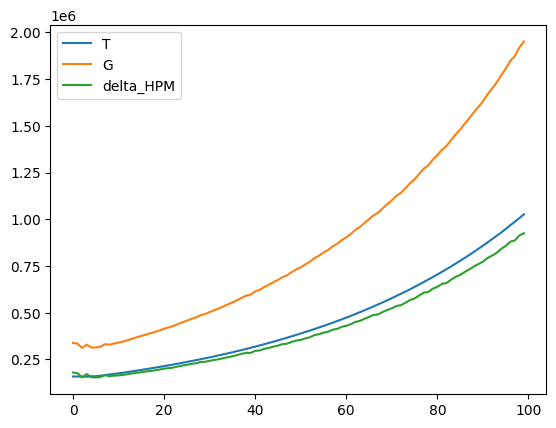

In [7]:
agg_government_df = pd.read_csv(simulation.path + '/aggregate_government.csv')
for col in list(agg_government_df.columns):
    print(col)
agg_government_df.head()

In [8]:
plt.plot(agg_government_df["tax_mean"], label="T")
plt.plot(agg_government_df["expenditure_mean"], label="G")
plt.plot(agg_government_df["delta_HPM_mean"], label="delta_HPM")
plt.legend()
len(agg_government_df)

index
round
firm_name_ttl
firm_name_mean
firm_name_std
profit_ttl
profit_mean
profit_std
profit_after_tax_ttl
profit_after_tax_mean
profit_after_tax_std
dividend_ttl
dividend_mean
dividend_std
undistributed_profit_ttl
undistributed_profit_mean
undistributed_profit_std
net_lending_ttl
net_lending_mean
net_lending_std
wage_sum_ttl
wage_sum_mean
wage_sum_std
firm_income_ttl
firm_income_mean
firm_income_std
tax_sum_ttl
tax_sum_mean
tax_sum_std
delta_L_ttl
delta_L_mean
delta_L_std
delta_MS_ttl
delta_MS_mean
delta_MS_std
price_of_product_ttl
price_of_product_mean
price_of_product_std


,index,round,firm_name_ttl,firm_name_mean,firm_name_std,profit_ttl,profit_mean,profit_std,profit_after_tax_ttl,profit_after_tax_mean,...,tax_sum_std,delta_L_ttl,delta_L_mean,delta_L_std,delta_MS_ttl,delta_MS_mean,delta_MS_std,price_of_product_ttl,price_of_product_mean,price_of_product_std
0,1,0,0.0,0.0,0.0,187841.983921,187841.983921,0.0,150273.587137,150273.587137,...,0.0,381691.127067,381691.127067,0.0,516937.355490,516937.355490,0.0,1.0,1.0,0.0
1,2,1,0.0,0.0,0.0,177790.215816,177790.215816,0.0,142232.172653,142232.172653,...,0.0,385458.479429,385458.479429,0.0,513467.434816,513467.434816,0.0,1.0,1.0,0.0
2,3,2,0.0,0.0,0.0,169850.793100,169850.793100,0.0,135880.634480,135880.634480,...,0.0,389948.925448,389948.925448,0.0,512241.496480,512241.496480,0.0,1.0,1.0,0.0
3,4,3,0.0,0.0,0.0,157501.386200,157501.386200,0.0,126001.108960,126001.108960,...,0.0,393338.845584,393338.845584,0.0,506739.843648,506739.843648,0.0,1.0,1.0,0.0
4,5,4,0.0,0.0,0.0,154147.765793,154147.765793,0.0,123318.212635,123318.212635,...,0.0,399384.541019,399384.541019,0.0,510370.932390,510370.932390,0.0,1.0,1.0,0.0


In [9]:
aggregate_firmC_df = pd.read_csv(simulation.path + '/aggregate_firmC.csv')
for col in list(aggregate_firmC_df.columns):
    print(col)
aggregate_firmC_df.head()

,index,round,wage_ttl,wage_mean,wage_std,dividend_income_ttl,dividend_income_mean,dividend_income_std,income_from_government_ttl,income_from_government_mean,...,consumption_std,real_consumption_ttl,real_consumption_mean,real_consumption_std,delta_L_ttl,delta_L_mean,delta_L_std,delta_MS_ttl,delta_MS_mean,delta_MS_std
0,1,0,329092.371569,329.092372,263.033667,15027.358714,15.027359,46.452004,37927.756617,37.927757,...,144.154643,216934.355490,216.934355,144.154643,469563.067296,469.563067,316.996768,392848.710440,392.848710,219.475877
1,2,1,335674.219000,335.674219,267.805831,14223.217265,14.223217,46.328252,34063.514115,34.063514,...,127.412362,213464.434816,213.464435,127.412362,301512.377542,301.512378,244.010090,226897.052168,226.897052,176.879606
2,3,2,342387.703380,342.387703,272.828518,13588.063448,13.588063,45.721200,11537.029340,11.537029,...,121.618623,212238.496480,212.238496,121.618623,301729.492199,301.729492,241.445524,208082.322999,208.082323,207.157648
3,4,3,349235.457448,349.235457,277.471865,12600.110896,12.600111,41.682773,28720.269809,28.720270,...,127.523340,206736.843648,206.736844,127.523340,304451.890557,304.451891,243.034945,236304.871222,236.304871,186.375255
4,5,4,356220.166597,356.220167,283.049991,12331.821263,12.331821,42.580285,13673.068993,13.673069,...,126.021795,210367.932390,210.367932,126.021795,310045.291871,310.045292,245.136112,224998.312953,224.998313,209.477797


100

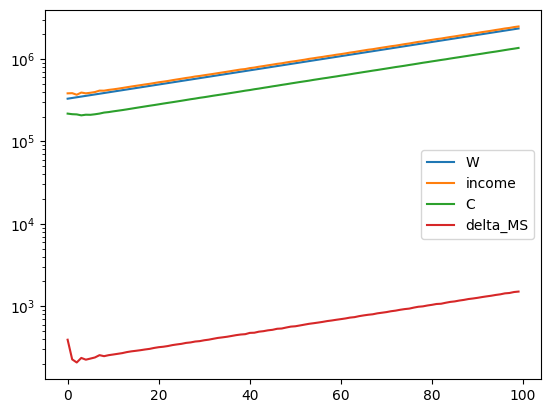

In [10]:
agg_hh_df = pd.read_csv(simulation.path + '/aggregate_household.csv')
agg_hh_df.head()

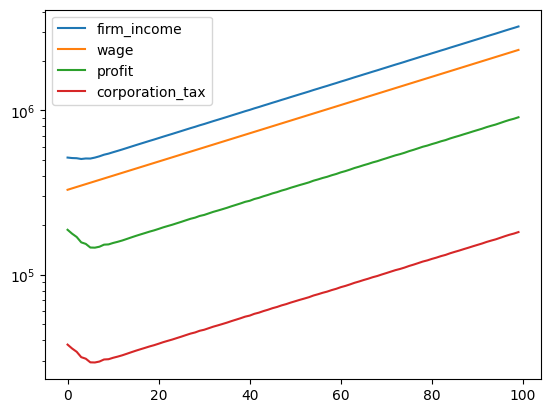

In [11]:
#plt.plot(agg_hh_df["wage_mean"], label="W")
#plt.plot(agg_hh_df["income_mean"], label="income")
#plt.plot(agg_hh_df["consumption_mean"], label="C")
plt.plot(agg_hh_df["delta_MS_mean"], label="delta_MS")
plt.plot(agg_hh_df["delta_L_mean"], label="delta_L")
#plt.yscale("log")
plt.legend()

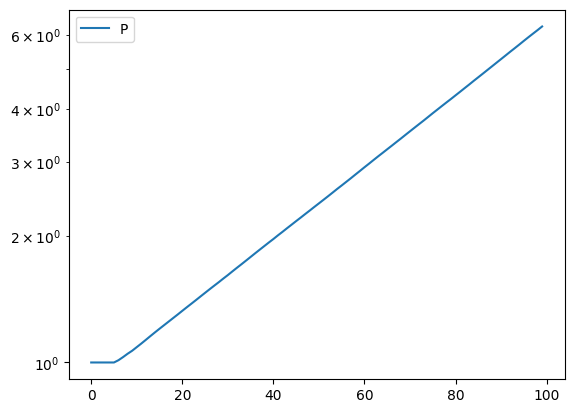

In [12]:
plt.plot(aggregate_firmC_df["firm_income_mean"], label="firm_income")
plt.plot(aggregate_firmC_df["wage_sum_mean"], label="wage")
plt.plot(aggregate_firmC_df["profit_mean"], label="profit")
plt.plot(aggregate_firmC_df["tax_sum_mean"], label="corporation_tax")
plt.plot(np.zeros(len(aggregate_firmC_df)), color="black")
plt.yscale("log")
plt.legend()

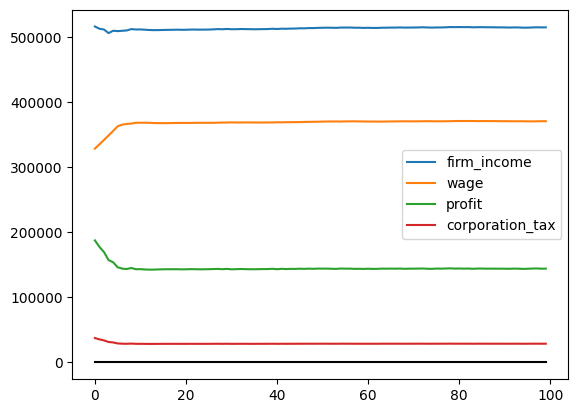

In [13]:
plt.plot(aggregate_firmC_df["price_of_product_ttl"], label="P")
plt.yscale("log")
plt.legend()

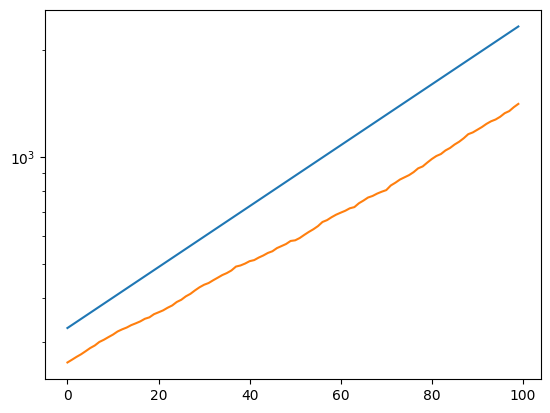

In [14]:
P = aggregate_firmC_df["price_of_product_ttl"]
plt.plot(aggregate_firmC_df["firm_income_mean"]/P, label="firm_income")
plt.plot(aggregate_firmC_df["wage_sum_mean"]/P, label="wage")
plt.plot(aggregate_firmC_df["profit_mean"]/P, label="profit")
plt.plot(aggregate_firmC_df["tax_sum_mean"]/P, label="corporation_tax")
plt.plot(np.zeros(len(aggregate_firmC_df)), color="black")
plt.legend()

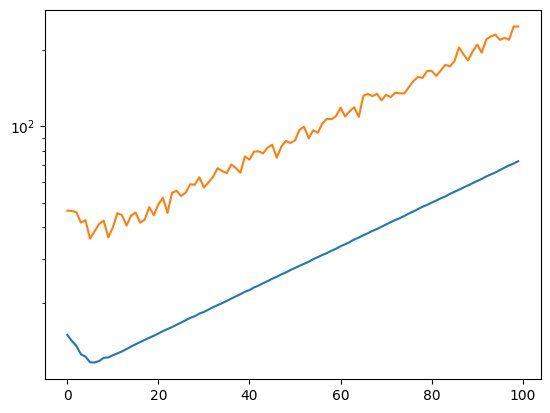

In [15]:
plt.plot(agg_hh_df["wage_mean"], label="wage mean")
plt.plot(agg_hh_df["wage_std"], label="wage std")
plt.yscale("log")
plt.legend()

In [ ]:
plt.plot(agg_hh_df["dividend_income_mean"], label="dividend mean")
plt.plot(agg_hh_df["dividend_income_std"], label="dividend std")
plt.yscale("log")
plt.legend()

In [ ]:
P = aggregate_firmC_df["price_of_product_ttl"]
plt.plot(agg_government_df["tax_mean"]/P, label="T")
plt.plot(agg_government_df["expenditure_mean"]/P, label="G")
plt.legend()